<a href="https://colab.research.google.com/github/liavsi/FinTechWorkshop/blob/main/Machine_Learning/Models_Comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set Seaborn style
sns.set()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load and Inspect the Dataset

In [ ]:
def load_dataset(file_path):
    data = pd.read_csv(file_path)
    return data

train_csv_path = '/content/drive/MyDrive/Fintech Workshop - ML liquidity/csv files from 01-01-2024 to 08-05-2024/DataTable_2024-01-02.csv'
data = load_dataset(train_csv_path)

# Convert Date column to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Hour'] = data['Date'].dt.hour
data['Minute'] = data['Date'].dt.minute
data['Second'] = data['Date'].dt.second

# Drop the original Date column
data = data.drop(columns=['Date'])

data.head()

,Transaction_ID,Name,Price,Side,Volume,Order_Executed,Target,Hour,Minute,Second
0,113,373019,12090000.0,1,900,0,90,7,25,1
1,117,175018,112000000.0,1,107,0,0,7,25,1
2,118,442012,15000000.0,1,5773,0,0,7,25,1
3,119,1105907,2050000.0,0,952,0,0,7,25,1
4,120,3830155,37000.0,0,7500,0,0,7,25,1


Visualize the Data

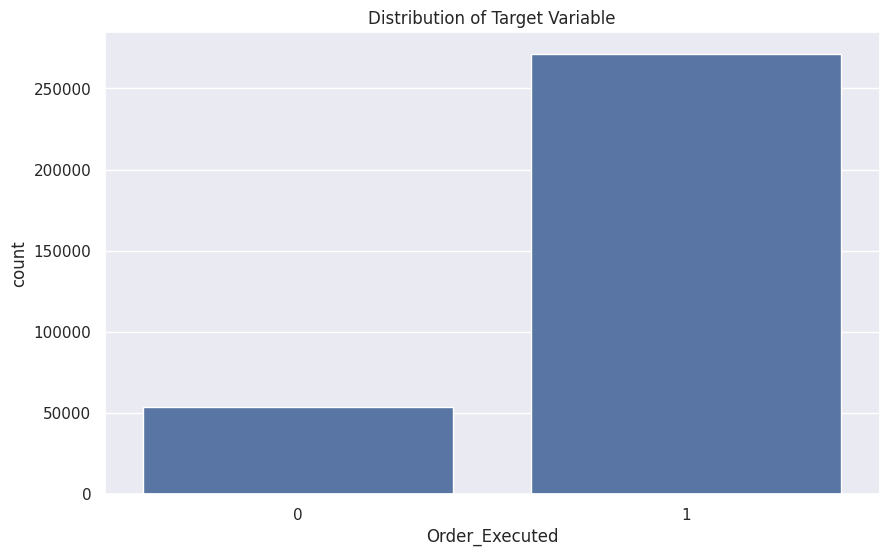

In [ ]:
# Distribution of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='Order_Executed', data=data)
plt.title('Distribution of Target Variable')
plt.show()


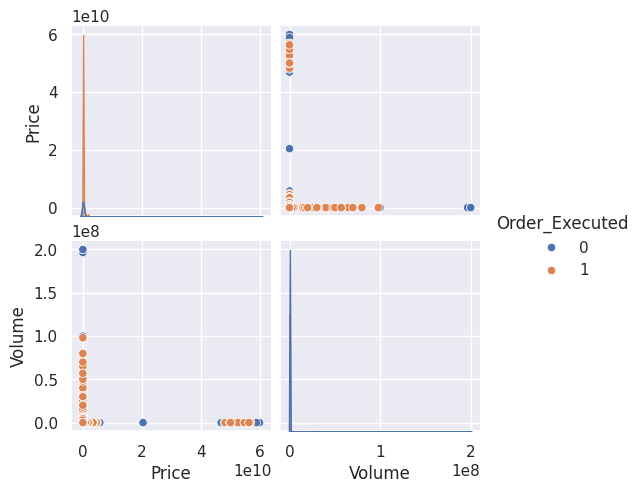

In [ ]:
# Pairplot to see relationships between numerical features
numerical_features = ['Price', 'Volume']
sns.pairplot(data[numerical_features + ['Order_Executed']], hue='Order_Executed')
plt.show()

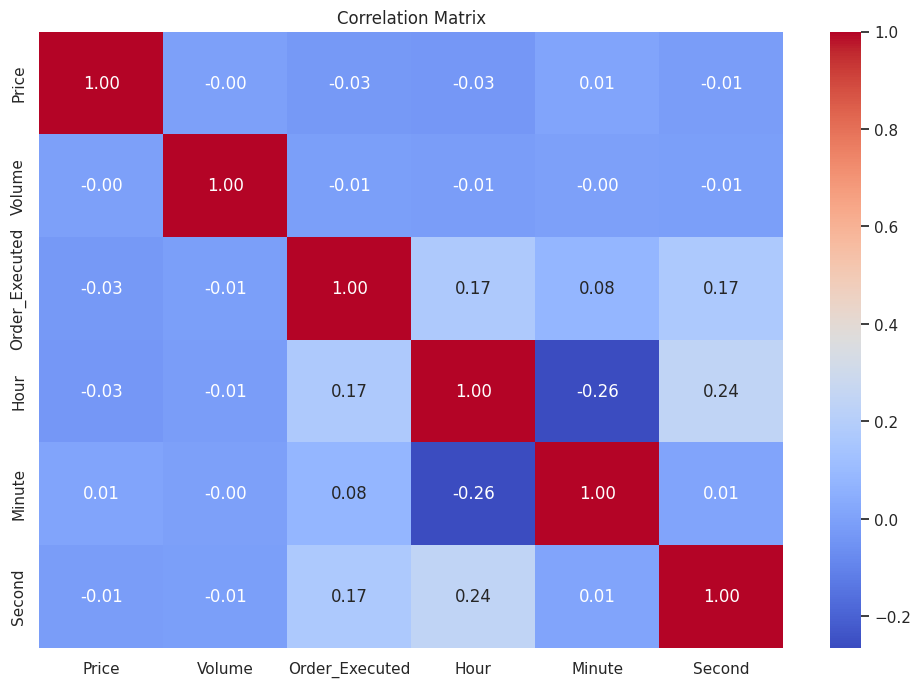

In [ ]:
# Correlation heatmap
# Drop non-numeric columns for correlation matrix calculation
correlation_data = data.drop(columns=['Transaction_ID', 'Name', 'Target', 'Side'])

# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

 Heatmap of Volume vs. Time of Day

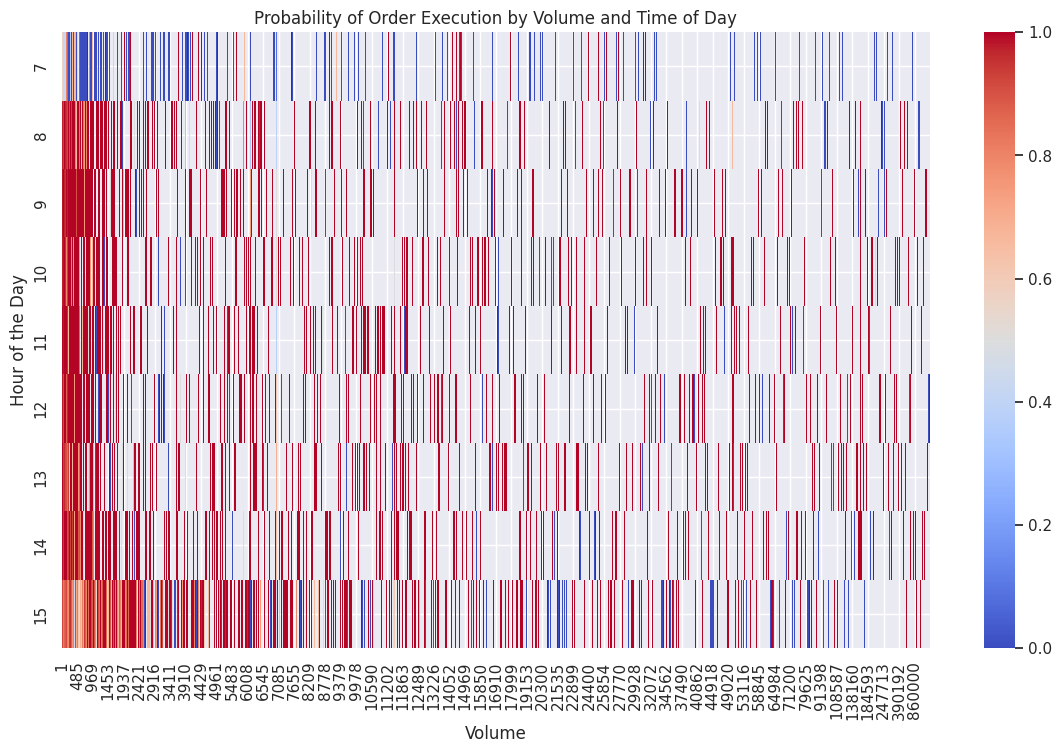

In [ ]:
# Pivot table for heatmap
heatmap_data = data.pivot_table(index='Hour', columns='Volume', values='Order_Executed', aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=False)
plt.title('Probability of Order Execution by Volume and Time of Day')
plt.xlabel('Volume')
plt.ylabel('Hour of the Day')
plt.show()

Scatter Plot of Volume vs. Time of Day

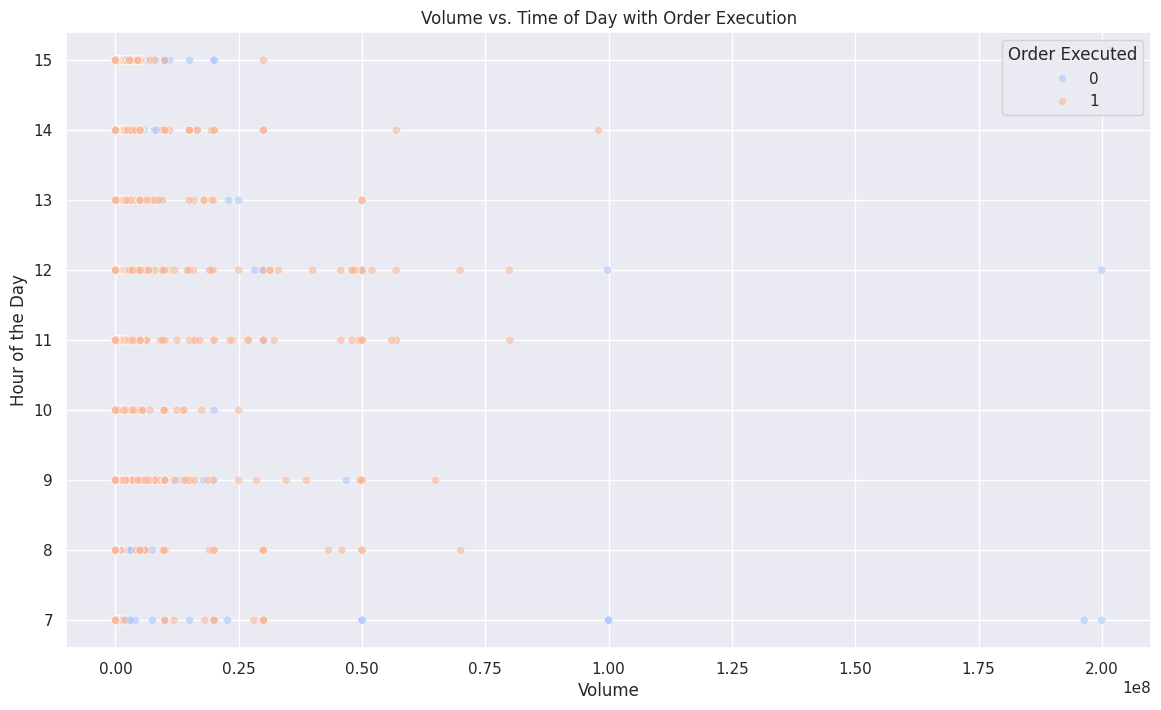

In [ ]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='Volume', y='Hour', hue='Order_Executed', data=data, palette='coolwarm', alpha=0.6)
plt.title('Volume vs. Time of Day with Order Execution')
plt.xlabel('Volume')
plt.ylabel('Hour of the Day')
plt.legend(title='Order Executed')
plt.show()

Line Plot of Average Execution Probability by Hour

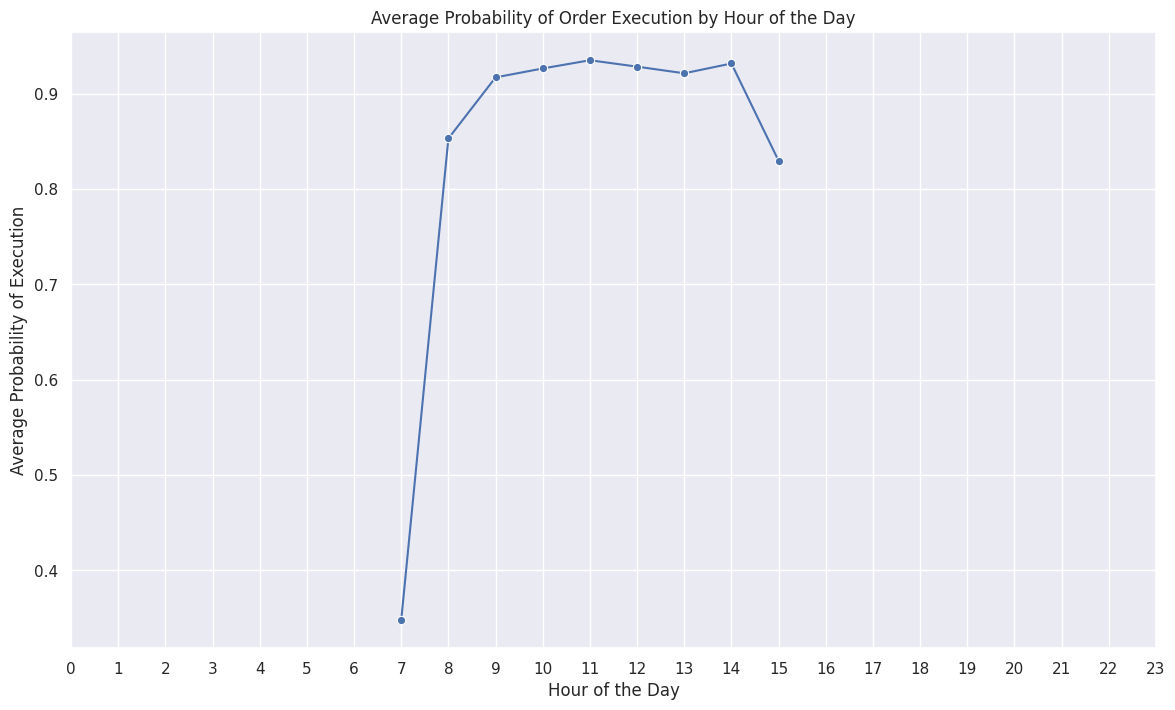

In [ ]:
# Group by hour and calculate mean probability of execution
hourly_data = data.groupby('Hour')['Order_Executed'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(x='Hour', y='Order_Executed', data=hourly_data, marker='o')
plt.title('Average Probability of Order Execution by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Probability of Execution')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

Predictive Modeling for Order Execution: Determining the Likelihood of Order Fulfillment

In [ ]:

def load_dataset(file_path):
    data = pd.read_csv(file_path)
    return data

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_column):
        self.date_column = date_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        X['Year'] = X[self.date_column].dt.year
        X['Month'] = X[self.date_column].dt.month
        X['Day'] = X[self.date_column].dt.day
        X['Hour'] = X[self.date_column].dt.hour
        X['Minute'] = X[self.date_column].dt.minute
        X['Second'] = X[self.date_column].dt.second
        X = X.drop(columns=[self.date_column])
        return X

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.categorical_features = ['Side', 'Target']
        self.numerical_features = ['Name', 'Price', 'Volume', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']
        self.transformer = None

    def fit(self, X, y=None):
        # Categorical pipeline
        categorical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ])

        # Numerical pipeline
        numerical_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        # Column transformer
        self.transformer = ColumnTransformer([
            ('categorical', categorical_pipeline, self.categorical_features),
            ('numerical', numerical_pipeline, self.numerical_features)
        ])

        # Fit the transformer
        self.transformer.fit(X)
        return self

    def transform(self, X):
        # Apply the transformer
        return self.transformer.transform(X)

def train_model(X, y, model_type='gradient_boosting'):
    if model_type == 'random_forest':
        model = RandomForestClassifier()
    elif model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'svm':
        model = SVC()
    elif model_type == 'gradient_boosting':
        model = GradientBoostingClassifier()
    else:
        raise ValueError("Invalid model_type.")

    model.fit(X, y)
    return model

def evaluate_models():
    preprocessor = DataPreprocessor()
    date_transformer = DateTransformer(date_column='Date')
    train_csv_path = '/content/drive/MyDrive/Fintech Workshop - ML liquidity/csv files from 01-01-2024 to 08-05-2024/DataTable_2024-01-02.csv'
    data = load_dataset(train_csv_path)

    X = data.drop(columns=['Order_Executed'])
    y = data['Order_Executed']

    # Transform the date column
    X = date_transformer.transform(X)

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the preprocessor
    preprocessor.fit(X_train)
    X_train_processed = preprocessor.transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    results = []

    # Evaluate different models
    for model_type in ['random_forest', 'logistic_regression', 'gradient_boosting']:
        model = train_model(X_train_processed, y_train, model_type)

         # Predict and evaluate
        y_train_pred = model.predict(X_train_processed)
        y_test_pred = model.predict(X_test_processed)

        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)

        results.append({
            'model': model_type,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        })

    return pd.DataFrame(results)



results = evaluate_models()
results

,model,train_accuracy,test_accuracy
0,random_forest,0.999661,0.954373
1,logistic_regression,0.843399,0.841821
2,gradient_boosting,0.945591,0.944071


Visualize Model Performance

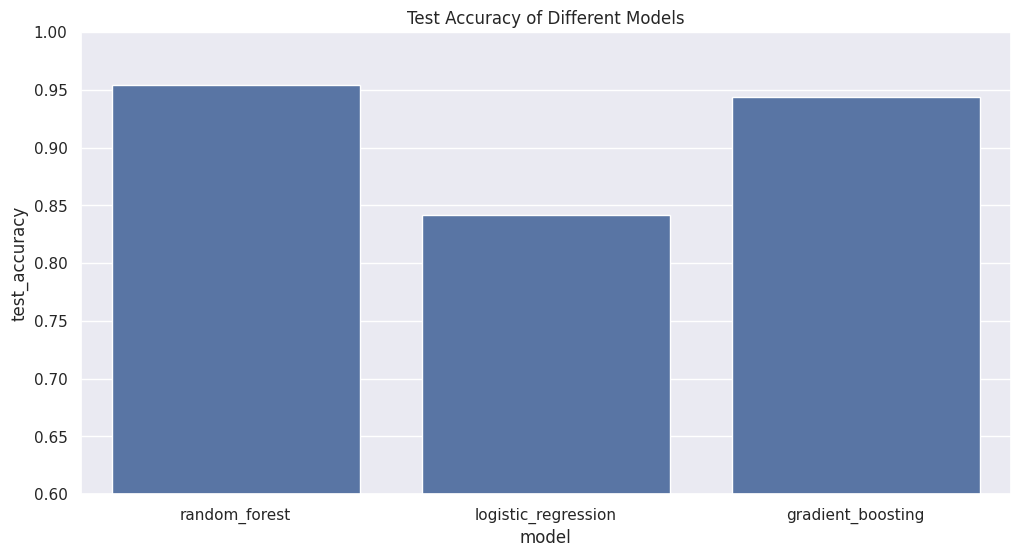

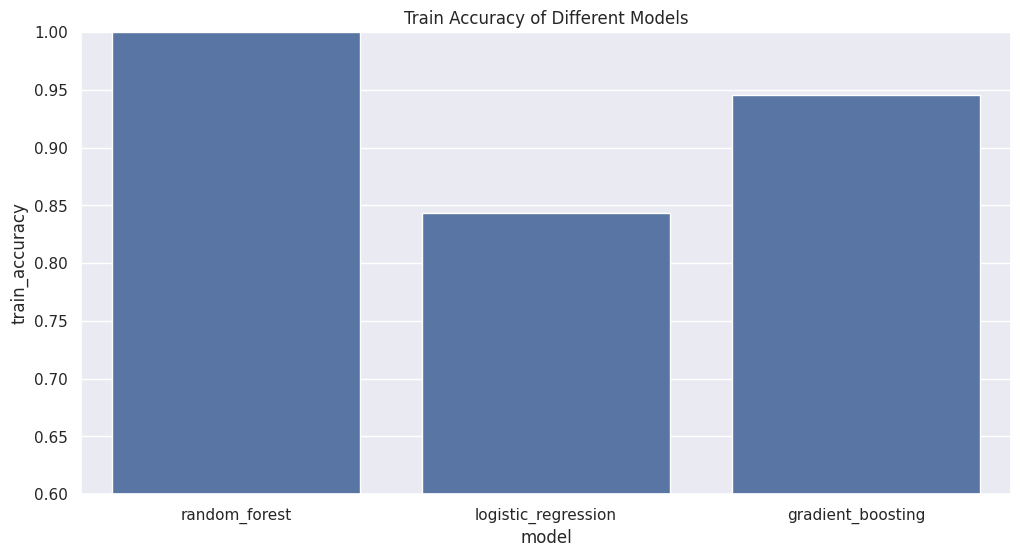

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='test_accuracy', data=results)
plt.ylim(0.6, 1)
plt.yticks(np.arange(0.6, 1.01, 0.05)) # more detail
plt.title('Test Accuracy of Different Models')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='train_accuracy', data=results)
plt.ylim(0.6, 1)
plt.yticks(np.arange(0.6, 1.01, 0.05)) # more detail
plt.title('Train Accuracy of Different Models')
plt.show()